In [59]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import traceback

In [60]:
# Define the root directory and dataset name
DATA_ROOT = r'E:\RABBIT_DATA\NEW_AI_RESULTS_V11\\'
DATA_NAME = 'Rabbit'

# Voxel dimensions in nanometers
VOXEL_SIZE_X = 55.5
VOXEL_SIZE_Y = 55.5
VOXEL_SIZE_Z = 150

# Conversion factor from nanometers to micrometers
UNIT_CONVERSION = 1e3

# Flag to determine data processing mode
AGGREGATE_DATA = False  # Set to False to process each cell individually

# Flag to control plotting of only one example cell in per-cell analysis
SHOW_ONLY_ONE_CELL_PLOT = True  # Set to False to plot all cells

APPLY_TUKEY_FILTER = True  # Set to True to apply Tukey's Fences filtration

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.ticker as ticker  # Import ticker for custom tick formatting

def power_function(x, a, b):
    return a * x**b

def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def analyze_data(data_raw, data_name='Data', show_plots=True, nbins=50):
    # Parameters to control font sizes
    legend_fontsize = 12       # Size of the legend fonts
    axis_title_fontsize = 14   # Size of the axis titles
    tick_label_fontsize = 12   # Size of the tick labels

    normalized_data = np.array(data_raw)

    NBINS = nbins
    values, bin_edges = np.histogram(np.array(data_raw), bins=NBINS)
    peak_idx = values.argmax()
    half_peak_value = values[peak_idx] / 2
    values_before_peak = values[:peak_idx]
    indices_less_than_half = np.nonzero(values_before_peak < half_peak_value)[0]
    if len(indices_less_than_half) == 0:
        inflection_idx = peak_idx
    else:
        inflection_idx = indices_less_than_half[np.abs(values_before_peak[indices_less_than_half] - half_peak_value).argmin()]

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    first_bins_centers = bin_centers[:inflection_idx+1]
    first_bins_values = values[:inflection_idx+1]

    # Filter out zero counts to avoid log10(0)
    nonzero_mask = first_bins_values > 0
    first_bins_centers = first_bins_centers[nonzero_mask]
    first_bins_values = first_bins_values[nonzero_mask]

    # Check if enough data points are available for fitting
    if len(first_bins_centers) < 2:
        raise ValueError("Not enough data points for curve fitting after filtering.")

    # Fit the power function to the log-log data
    log_first_bins_centers = np.log10(first_bins_centers)
    log_first_bins_values = np.log10(first_bins_values)
    params, _ = curve_fit(lambda x, a, b: a + b*x, log_first_bins_centers, log_first_bins_values)
    a, b = params

    # Calculate the fitted line in log-log space
    log_y_fit = a + b * log_first_bins_centers
    y_fit = 10**log_y_fit

    residuals = first_bins_values - y_fit
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((first_bins_values - np.mean(first_bins_values)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    # Create the plot
    fig = plt.figure(figsize=(10, 6), dpi=300)
    plt.hist(normalized_data, bins=NBINS, alpha=0.6, edgecolor='black', label='RyR Cluster Nearest Neighbor Distances')
    plt.scatter(first_bins_centers, first_bins_values, c='red', label='Bins (up to inflection point)')
    plt.plot(first_bins_centers, y_fit, c='blue', label='Fitted Power Function')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Nearest Neighbor Distances (nm)', fontsize=axis_title_fontsize)
    plt.ylabel('Count', fontsize=axis_title_fontsize)
    plt.title(f'Log-Log Histogram with Fitted Line for RYR Nearest Neighbor Distances in {data_name}', fontsize=axis_title_fontsize)

    # Adjust x-axis ticks for log scale
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=tick_label_fontsize)
    ax.tick_params(axis='both', which='minor', labelsize=tick_label_fontsize)

    # Set specific tick positions and labels
    tick_positions = [300, 400, 600, 1000]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels([str(tick) for tick in tick_positions], rotation=45)

    # Adjust layout to make room for the rotated x-axis labels and legend
    plt.tight_layout()
    
    # Place the legend below the plot with increased spacing
    legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=1, fontsize=legend_fontsize)
    
    # Increase spacing between legend entries
    legend._loc = 2  # Upper left corner (this doesn't change its position, just internal layout)
    legend._labelspacing = 1.5  # Increase this value for more vertical spacing between legend entries

    # Adjust the bottom margin to accommodate the legend
    plt.subplots_adjust(bottom=0.3)

    if show_plots:
        plt.show()

    return b, r_squared, fig

In [66]:
def get_matching_files(root_dir, pattern):
    """
    Recursively find files matching the given pattern in the directory and sub-directories.
    """
    matching_files = []
    for current_root, dirs, files in os.walk(root_dir):
        for file_name in files:
            if pattern in file_name:
                matching_files.append(os.path.join(current_root, file_name))
    return matching_files

def extract_file_type(file_name):
    """
    Extract the specific file type from the filename, handling complex names.
    """
    parts = file_name.split('_')
    try:
        if "cluster" in file_name:
            type_part = '_'.join(parts[parts.index('labels') + 1:]).rsplit('.', 1)[0]
        else:
            type_part = parts[-1].split('.')[0]
    except ValueError:
        type_part = file_name.rsplit('.', 1)[0]
    return type_part

def collect_files(root_dir, filter_dir):
    """
    Collect specific files and organize them into a DataFrame, filtered by matching .jpg files in a directory.
    """
    # Collect all .jpg files in the filter directory
    filter_files = {os.path.basename(f): f for f in get_matching_files(filter_dir, '.jpg')}
    print(f"Found {len(filter_files)} .jpg files for filtering in {filter_dir}")
    
    data_records = []
    # Walk through each subdirectory and check for matching .jpg file presence
    for subdir, dirs, files in os.walk(root_dir):
        # Skip the filter_dir (CELLS_TO_USE directory) while processing subdirectories
        if os.path.abspath(subdir) == os.path.abspath(filter_dir):
            continue
        
        subdir_jpg_files = [f for f in files if f.endswith('.jpg')]
        if any(jpg in filter_files for jpg in subdir_jpg_files):
            file_dict = {}
            for file_name in files:
                file_type = extract_file_type(file_name)
                if file_type in ['adj_matrix', 'alphashape', 'centroids', 'clusterlabels', 
                                 'filteredvolume', 'neighboralphacentroid', 'surfacearea', 
                                 'volume', 'volumes', 'voxellist', 'adjmatrix']:
                    file_dict[file_type] = os.path.join(subdir, file_name)
            if file_dict:
                data_records.append(file_dict)
    
    # Create DataFrame
    data_df = pd.DataFrame(data_records)
    if data_df.empty:
        print("No data collected. DataFrame is empty.")
    else:
        print("DataFrame created successfully with collected files.")
    return data_df

filter_directory = os.path.join(DATA_ROOT, 'CELLS_TO_USE')

# Collect files and create input DataFrame
input_dataframe = collect_files(DATA_ROOT, filter_directory)

# Extract the list of volume files to process
volume_files = input_dataframe['volumes'].tolist()
print(f"Found {len(volume_files)} volume files to process.")


filter_directory = os.path.join(DATA_ROOT, 'CELLS_TO_USE')

# Collect files and create input DataFrame
input_dataframe = collect_files(DATA_ROOT, filter_directory)

# Extract the list of neighboralphacentroid files to process
distance_files = input_dataframe['neighboralphacentroid'].tolist()
print(f"Found {len(distance_files)} neighboralphacentroid files to process.")

Found 31 .jpg files for filtering in E:\RABBIT_DATA\NEW_AI_RESULTS_V11\\CELLS_TO_USE
DataFrame created successfully with collected files.
Found 31 volume files to process.
Found 31 .jpg files for filtering in E:\RABBIT_DATA\NEW_AI_RESULTS_V11\\CELLS_TO_USE
DataFrame created successfully with collected files.
Found 31 neighboralphacentroid files to process.


In [67]:
# Ensure necessary imports
import os
import numpy as np
import pandas as pd
import traceback

def extract_cell_identifier(filename):
    """
    Extract the base name of the file without extension to use as the cell identifier.
    """
    base_name = os.path.basename(filename)
    name_without_ext = os.path.splitext(base_name)[0]
    return name_without_ext

# Helper function for Tukey's Fences filtration
def tukeys_fences(data, k=3.0):
    """
    Apply Tukey's Fences to filter out outliers from the data.
    Returns the filtered data.
    """
    data = np.array(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_fence = q1 - k * iqr
    upper_fence = q3 + k * iqr
    filtered_data = data[(data >= lower_fence) & (data <= upper_fence)]
    return filtered_data

# Initialize data container
if AGGREGATE_DATA:
    cumulative_distances = []
else:
    per_cell_data = {}  # Dictionary to store data per cell, including distances, surface area, volume, etc.

# Loop over the input_dataframe rows
for idx, row in input_dataframe.iterrows():
    # Get cell identifier
    cell_identifier = extract_cell_identifier(row['neighboralphacentroid'])
    print(f"Processing cell '{cell_identifier}' ({idx + 1}/{len(input_dataframe)})")

    # Read the distance data
    distance_file_path = row['neighboralphacentroid']
    df_distance = pd.read_csv(distance_file_path, header=None)
    distances_nm = df_distance.iloc[:, -1].values  # Assuming distances are in the last 

    # Apply Tukey's Fences filtration if enabled
    if APPLY_TUKEY_FILTER:
        distances_nm = tukeys_fences(distances_nm, k=3.0)

    # Read the surface area data
    surface_area_um2 = np.nan  # Initialize
    if 'surfacearea' in row and pd.notna(row['surfacearea']):
        surfacearea_file_path = row['surfacearea']
        if os.path.exists(surfacearea_file_path):
            df_surfacearea = pd.read_csv(surfacearea_file_path, header=None)
            # Assuming surface area is in the first column
            # Sum all values to get total surface area and convert to µm²
            surface_area_um2 = df_surfacearea.iloc[:, 0].sum() / 1e6  # Convert nm² to µm²
        else:
            print(f"Surface area file not found for cell '{cell_identifier}'")
    else:
        print(f"Surface area file not provided for cell '{cell_identifier}'")

    # Read the volume data
    volume_um3 = np.nan  # Initialize
    if 'volume' in row and pd.notna(row['volume']):
        volume_file_path = row['volume']
        if os.path.exists(volume_file_path):
            df_volume = pd.read_csv(volume_file_path, header=None)
            # Assuming volume is in the first column
            # Sum all values to get total volume and convert to µm³
            volume_um3 = df_volume.iloc[:, 0].sum() / 1e9  # Convert nm³ to µm³
        else:
            print(f"Volume file not found for cell '{cell_identifier}'")
    else:
        print(f"Volume file not provided for cell '{cell_identifier}'")

    if AGGREGATE_DATA:
        cumulative_distances.extend(distances_nm)
    else:
        # Store the data per cell
        per_cell_data[cell_identifier] = {
            'distances_nm': distances_nm,
            'surface_area_um2': surface_area_um2,
            'volume_um3': volume_um3,
        }

Processing cell 'RAW_55.5x55.5x150nm_image000002_3DCLAHE_neighboralphacentroid' (1/31)
Processing cell 'RAW_55.5x55.5x150nm_image000005-1_3DCLAHE_neighboralphacentroid' (2/31)
Processing cell 'RAW_55.5x55.5x150nm_image000006_3DCLAHE_neighboralphacentroid' (3/31)
Processing cell 'RAW_55.5x55.5x150nm_image000007_3DCLAHE_neighboralphacentroid' (4/31)
Processing cell 'RAW_55.5x55.5x150nm_image000008_3DCLAHE_neighboralphacentroid' (5/31)
Processing cell 'RAW_55.5x55.5x150nm_image000010_3DCLAHE_neighboralphacentroid' (6/31)
Processing cell 'RAW_55.5x55.5x150nm_image000011_3DCLAHE_neighboralphacentroid' (7/31)
Processing cell 'RAW_55.5x55.5x150nm_image000012_3DCLAHE_neighboralphacentroid' (8/31)
Processing cell 'RAW_55.5x55.5x150nm_image000015_3DCLAHE_neighboralphacentroid' (9/31)
Processing cell 'RAW_55.5x55.5x150nm_image000017_3DCLAHE_neighboralphacentroid' (10/31)
Processing cell 'RAW_55.5x55.5x150nm_image000018_3DCLAHE_neighboralphacentroid' (11/31)
Processing cell 'RAW_55.5x55.5x150nm_im

Example cell for visualization: RAW_55.5x55.5x150nm_image000002_3DCLAHE_neighboralphacentroid
Processing cell 'RAW_55.5x55.5x150nm_image000002_3DCLAHE_neighboralphacentroid'...


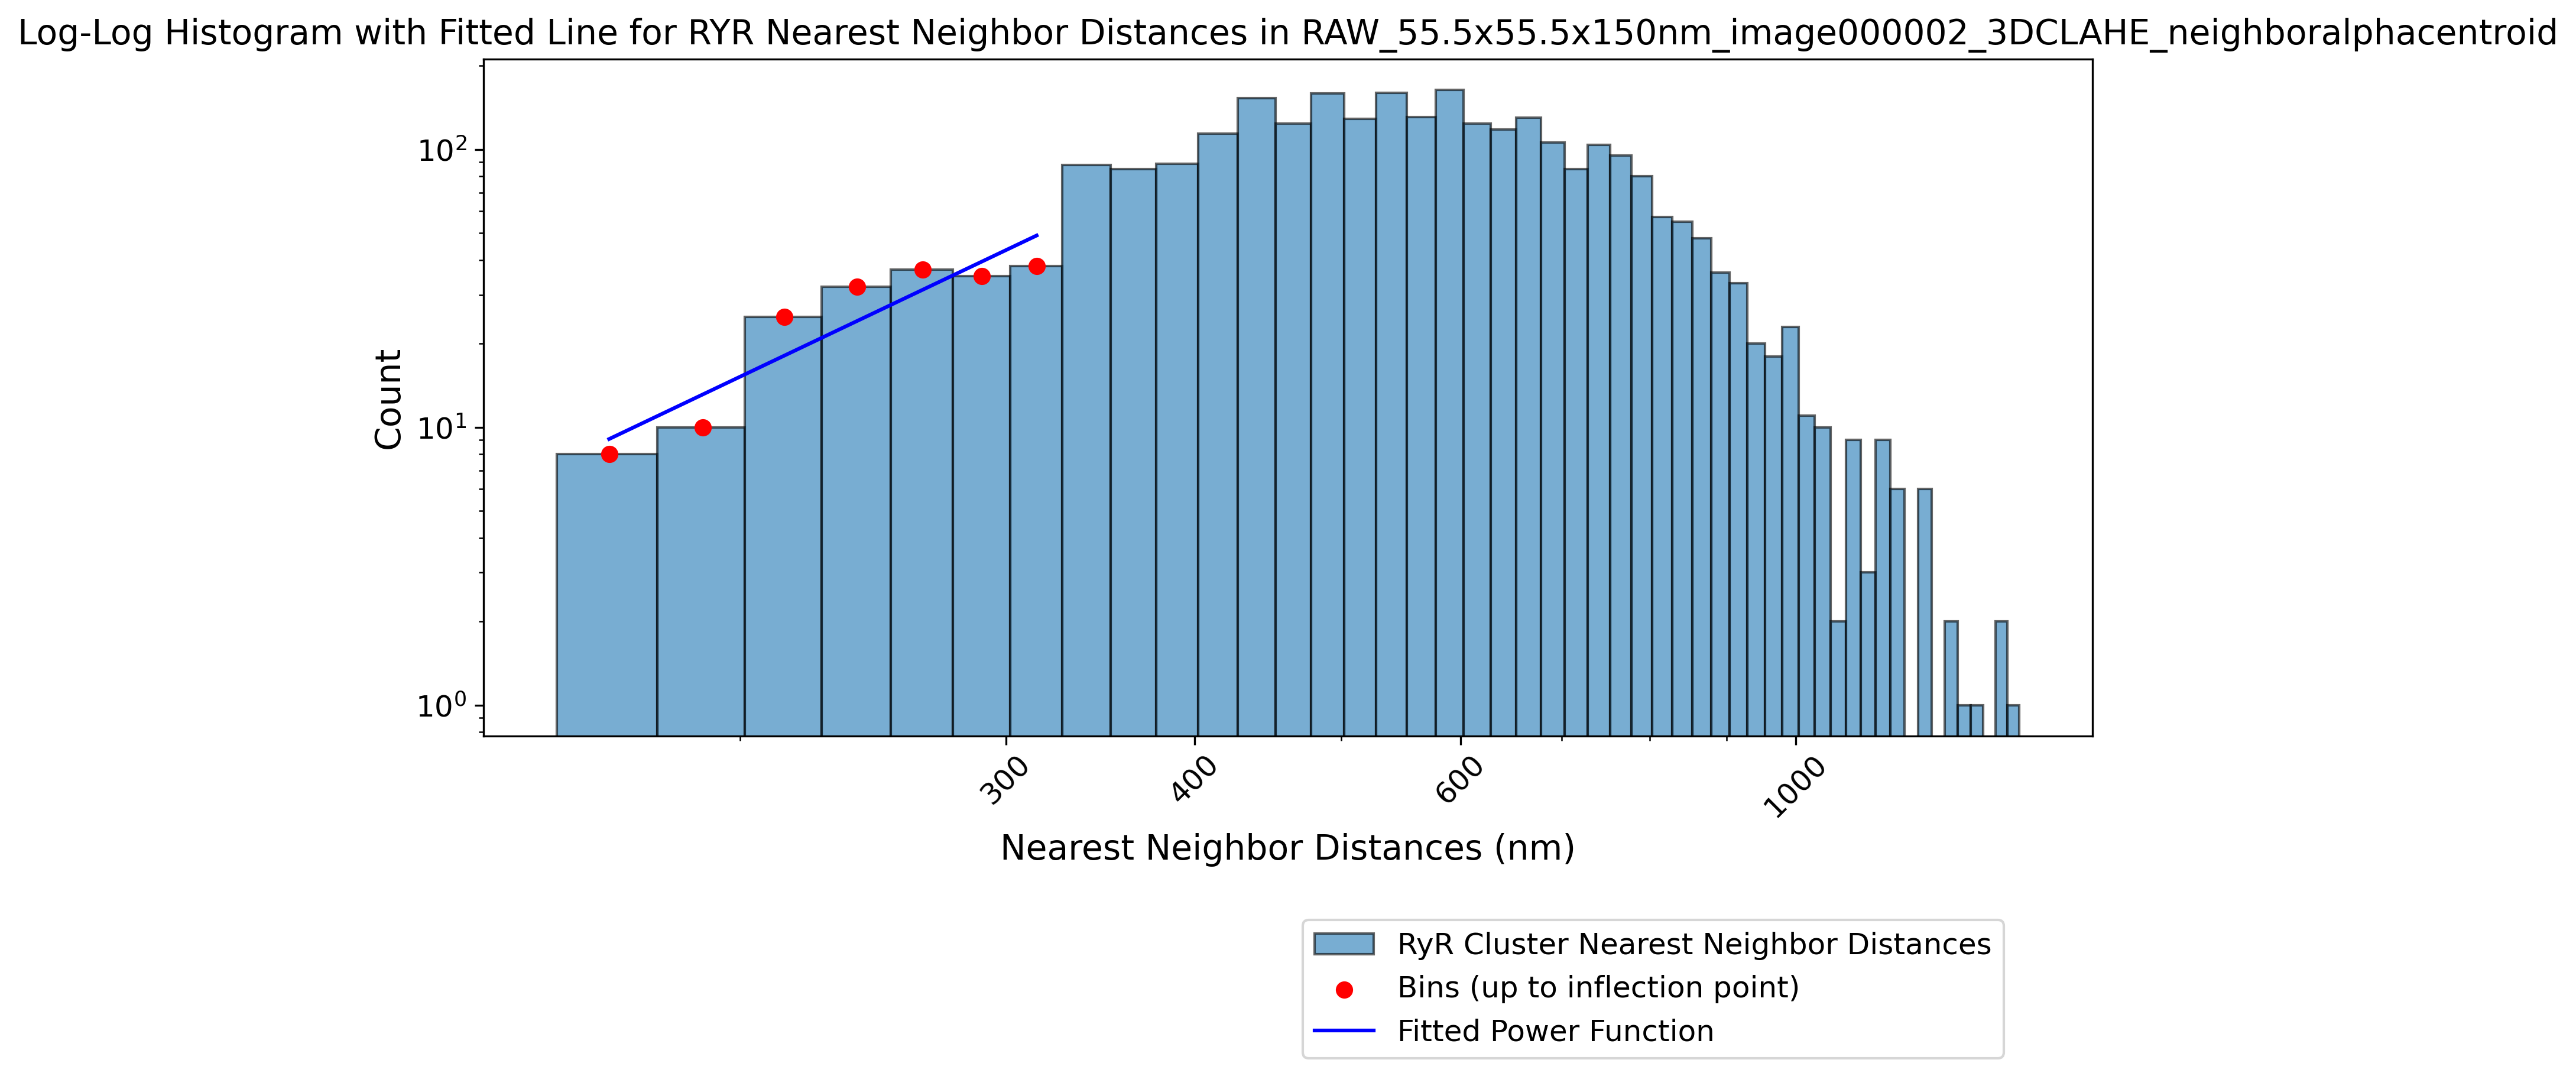

Processing cell 'RAW_55.5x55.5x150nm_image000005-1_3DCLAHE_neighboralphacentroid'...
Processing cell 'RAW_55.5x55.5x150nm_image000006_3DCLAHE_neighboralphacentroid'...
Processing cell 'RAW_55.5x55.5x150nm_image000007_3DCLAHE_neighboralphacentroid'...
Processing cell 'RAW_55.5x55.5x150nm_image000008_3DCLAHE_neighboralphacentroid'...
Processing cell 'RAW_55.5x55.5x150nm_image000010_3DCLAHE_neighboralphacentroid'...
Processing cell 'RAW_55.5x55.5x150nm_image000011_3DCLAHE_neighboralphacentroid'...
Processing cell 'RAW_55.5x55.5x150nm_image000012_3DCLAHE_neighboralphacentroid'...
Processing cell 'RAW_55.5x55.5x150nm_image000015_3DCLAHE_neighboralphacentroid'...
Processing cell 'RAW_55.5x55.5x150nm_image000017_3DCLAHE_neighboralphacentroid'...
Processing cell 'RAW_55.5x55.5x150nm_image000018_3DCLAHE_neighboralphacentroid'...
Processing cell 'RAW_55.5x55.5x150nm_image000021_3DCLAHE_neighboralphacentroid'...
Processing cell 'RAW_55.5x55.5x150nm_image000022_3DCLAHE_neighboralphacentroid'...
Pr

In [68]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters to control font sizes
legend_fontsize = 12       # Size of the legend fonts
axis_title_fontsize = 18   # Size of the axis titles
tick_label_fontsize = 16   # Size of the tick labels

# Apply the font size parameters
plt.rc('legend', fontsize=legend_fontsize)
plt.rc('axes', titlesize=axis_title_fontsize)
plt.rc('axes', labelsize=axis_title_fontsize)
plt.rc('xtick', labelsize=tick_label_fontsize)
plt.rc('ytick', labelsize=tick_label_fontsize)

# Ensure all x-axis labels are displayed
plt.rcParams['xtick.major.pad'] = 2
plt.rcParams['xtick.minor.pad'] = 2
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['figure.autolayout'] = True

output_dir = 'results'
os.makedirs(output_dir, exist_ok=True)

if AGGREGATE_DATA:
    # Prepare cumulative data for analysis
    print("Data aggregation completed. Proceeding with cumulative data analysis.")
    data_to_analyze = np.array(cumulative_distances)

    # Fit the power function to cumulative data
    print("Fitting power function to cumulative data...")
    try:
        b, r_squared, fig = analyze_data(
            data_to_analyze, data_name=DATA_NAME, show_plots=True, nbins=50
        )
        print('b value : ', b)
        print('Total clusters : ', len(data_to_analyze))
        # Save and close the figure
        plot_filename = os.path.join(output_dir, f'{DATA_NAME}_fitted_power_function_log_log.png')
        fig.savefig(plot_filename, dpi=300)
        plt.close(fig)
        print(f"Plot saved to {plot_filename}")

        # Collect the results
        results_dict = {
            'CellIdentifier': DATA_NAME,
            'Slope_b': round(b, 2),
            'R_squared': round(r_squared, 2)
        }

        # Save the results to a CSV file
        results_df = pd.DataFrame([results_dict])
        results_filename = os.path.join(output_dir, f'{DATA_NAME}_power_function_fit_results.csv')
        results_df.to_csv(results_filename, index=False)
        print(f"Results saved to {results_filename}")
    except Exception as e:
        print(f"Error processing cumulative data: {e}")
        traceback.print_exc()
else:
    # Initialize a list to collect fitted parameters and other metrics for all cells
    all_cells_results = []

    # Get a sorted list of cell identifiers
    sorted_cell_identifiers = sorted(per_cell_data.keys())
    # Choose one example cell to display in the notebook (e.g., the first cell)
    example_cell_identifier = sorted_cell_identifiers[0]
    print(f"Example cell for visualization: {example_cell_identifier}")

    for cell_identifier in sorted_cell_identifiers:
        cell_data = per_cell_data[cell_identifier]
        distances_nm = cell_data['distances_nm']
        surface_area_um2 = cell_data['surface_area_um2']
        volume_um3 = cell_data['volume_um3']
        cell_data_name = cell_identifier  # Use the original cell identifier for naming

        # Determine if we should show plots for this cell
        if SHOW_ONLY_ONE_CELL_PLOT and cell_identifier != example_cell_identifier:
            show_plots = False
        else:
            show_plots = True

        # Print statements for each cell
        print(f"Processing cell '{cell_identifier}'...")

        try:
            # Fit the power function to the data
            b, r_squared, fig = analyze_data(
                distances_nm, data_name=cell_data_name, show_plots=show_plots, nbins=50
            )

            # Save and close the figure
            plot_filename = os.path.join(output_dir, f'{cell_data_name}_fitted_power_function_log_log.png')
            fig.savefig(plot_filename, dpi=300)
            plt.close(fig)  # Close the figure to free up memory

            # Calculate mean and standard deviation of nearest neighbor distances
            mean_distance = np.mean(distances_nm)
            std_distance = np.std(distances_nm)

            # Collect the results
            results_dict = {
                'CellIdentifier': cell_identifier,
                'Slope_b': round(b, 2),
                'R_squared': round(r_squared, 2),
                'Mean_Distance_nm': round(mean_distance, 2),
                'Std_Distance_nm': round(std_distance, 2),
                'Surface_Area_um2': surface_area_um2,
                'Volume_um3': volume_um3,
            }
            all_cells_results.append(results_dict)
        except Exception as e:
            # Handle exceptions and continue with the next cell
            print(f"Error processing cell '{cell_identifier}': {e}")
            traceback.print_exc()
            # Append NaNs to maintain alignment
            results_dict = {
                'CellIdentifier': cell_identifier,
                'Slope_b': np.nan,
                'R_squared': np.nan,
                'Mean_Distance_nm': np.nan,
                'Std_Distance_nm': np.nan,
                'Surface_Area_um2': surface_area_um2,
                'Volume_um3': volume_um3,
            }
            all_cells_results.append(results_dict)
            continue  # Proceed to the next cell

    # After processing all cells, create a master DataFrame and save it

    # Print all collected results
    print("All cells results collected:")

    master_results_df = pd.DataFrame(all_cells_results)

    # Save the master table
    master_results_filename = os.path.join(output_dir, f'{DATA_NAME}_power_function_fit_results.csv')

    print(f"Saving master results to {master_results_filename}")
    master_results_df.to_csv(master_results_filename, index=False)
    print(f"Master fit results saved to {master_results_filename}")

In [69]:
### List all the cell identifiers
print("Available cells:")
cell_identifiers = list(per_cell_data.keys())
for idx, cell_identifier in enumerate(cell_identifiers):
    print(f"{idx+1}. {cell_identifier}")

Available cells:
1. RAW_55.5x55.5x150nm_image000002_3DCLAHE_neighboralphacentroid
2. RAW_55.5x55.5x150nm_image000005-1_3DCLAHE_neighboralphacentroid
3. RAW_55.5x55.5x150nm_image000006_3DCLAHE_neighboralphacentroid
4. RAW_55.5x55.5x150nm_image000007_3DCLAHE_neighboralphacentroid
5. RAW_55.5x55.5x150nm_image000008_3DCLAHE_neighboralphacentroid
6. RAW_55.5x55.5x150nm_image000010_3DCLAHE_neighboralphacentroid
7. RAW_55.5x55.5x150nm_image000011_3DCLAHE_neighboralphacentroid
8. RAW_55.5x55.5x150nm_image000012_3DCLAHE_neighboralphacentroid
9. RAW_55.5x55.5x150nm_image000015_3DCLAHE_neighboralphacentroid
10. RAW_55.5x55.5x150nm_image000017_3DCLAHE_neighboralphacentroid
11. RAW_55.5x55.5x150nm_image000018_3DCLAHE_neighboralphacentroid
12. RAW_55.5x55.5x150nm_image000021_3DCLAHE_neighboralphacentroid
13. RAW_55.5x55.5x150nm_image000022_3DCLAHE_neighboralphacentroid
14. RAW_55.5x55.5x150nm_image000025-1_3DCLAHE_neighboralphacentroid
15. RAW_55.5x55.5x150nm_image000027_3DCLAHE_neighboralphacentroi

In [ ]:
# Prompt the user to select a cell
while True:
    try:
        cell_index = int(input("Enter the number corresponding to the cell you wish to visualize: ")) - 1
        if 0 <= cell_index < len(cell_identifiers):
            break
        else:
            print("Invalid number. Please enter a number from the list.")
    except ValueError:
        print("Invalid input. Please enter a valid number.")


You have selected: RAW_55.5x55.5x150nm_image000067_3DCLAHE_neighboralphacentroid
676.189126984127


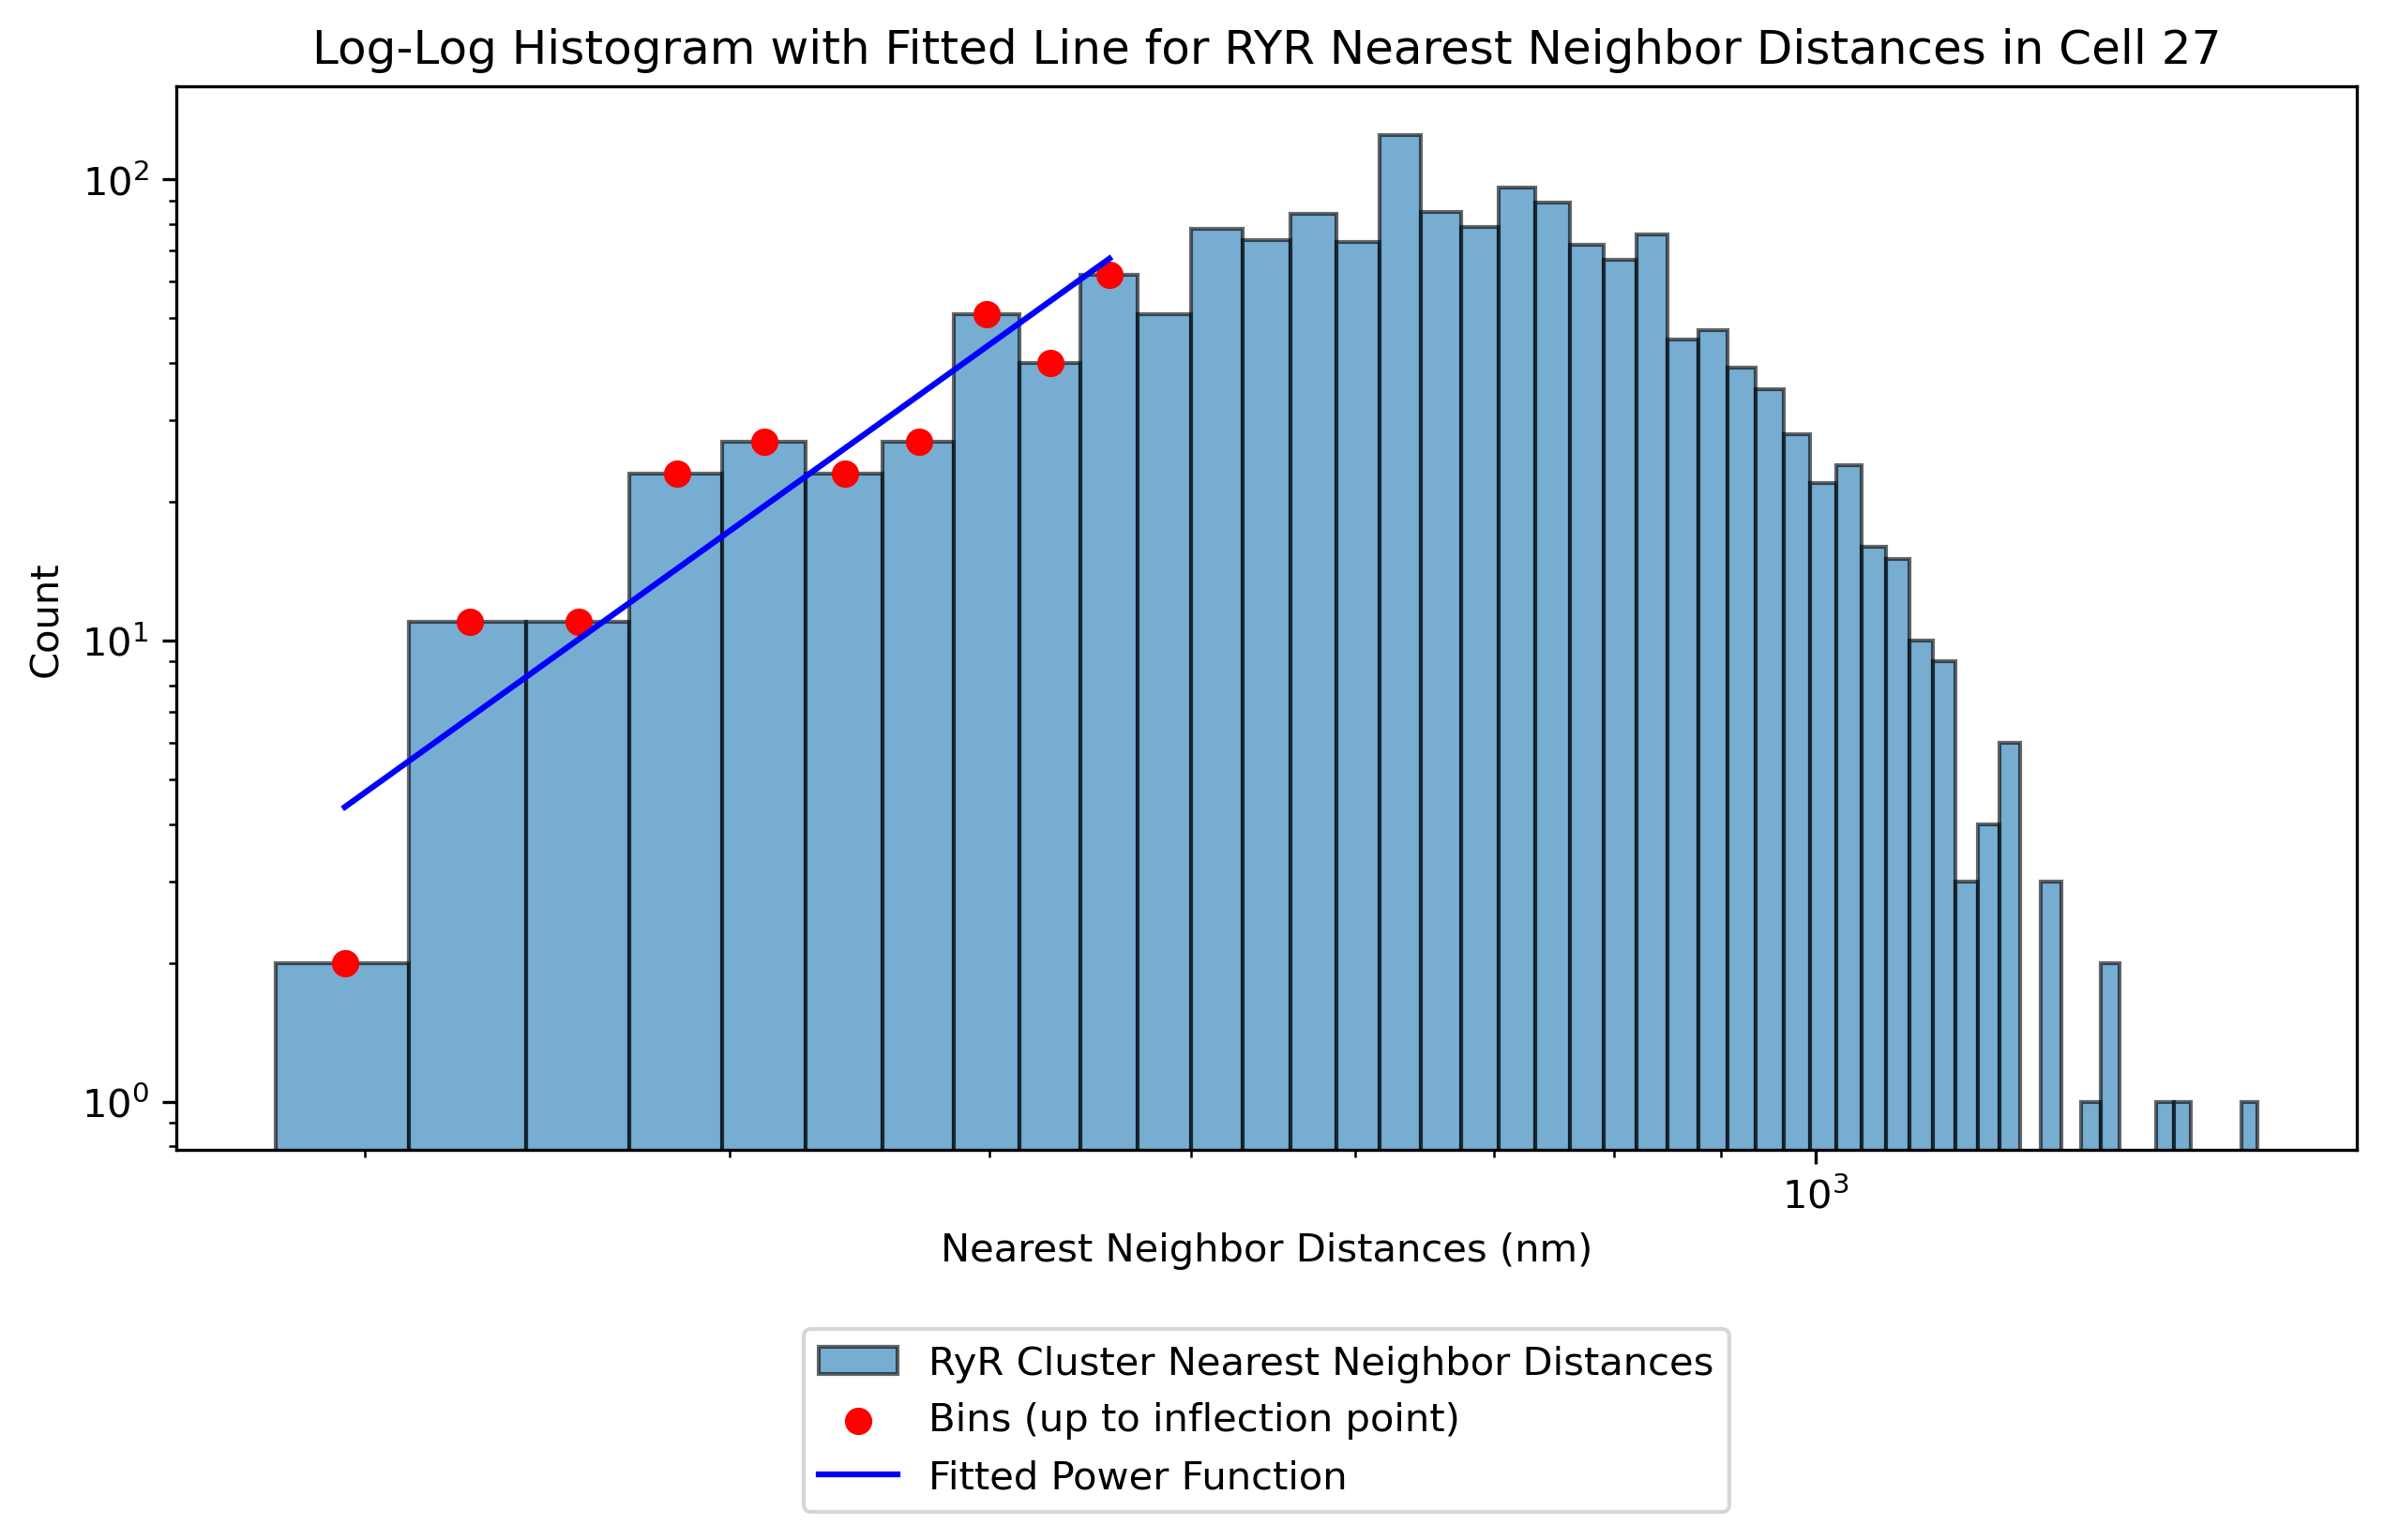

In [12]:
cell_index = 27 - 1

# Get the selected cell identifier
selected_cell_identifier = cell_identifiers[cell_index]
print(f"\nYou have selected: {selected_cell_identifier}")

# Retrieve the data for the selected cell
cell_data = per_cell_data[selected_cell_identifier]
distances_nm = cell_data['distances_nm']
print(np.average(distances_nm))
# Get the cell number (index + 1)
cell_number = cell_index + 1

# Define the function to plot the power function with provided data
def plot_power_function_log_log(distances_nm, cell_number, nbins=50):
    """
    Plot the power function to distance distribution log-log plot for a specific cell.
    """
    # Use the analyze_data function but customize the plot title
    try:
        b, r_squared, fig = analyze_data(
            distances_nm,
            data_name=f'Cell {cell_number}',
            show_plots=True,
            nbins=nbins
        )
    except Exception as e:
        print(f"Error analyzing data for cell {cell_number}: {e}")
        return
    # The analyze_data function already creates the plot and shows it

# Call the function to plot
plot_power_function_log_log(
    distances_nm,
    cell_number=cell_number,
    nbins=50
)

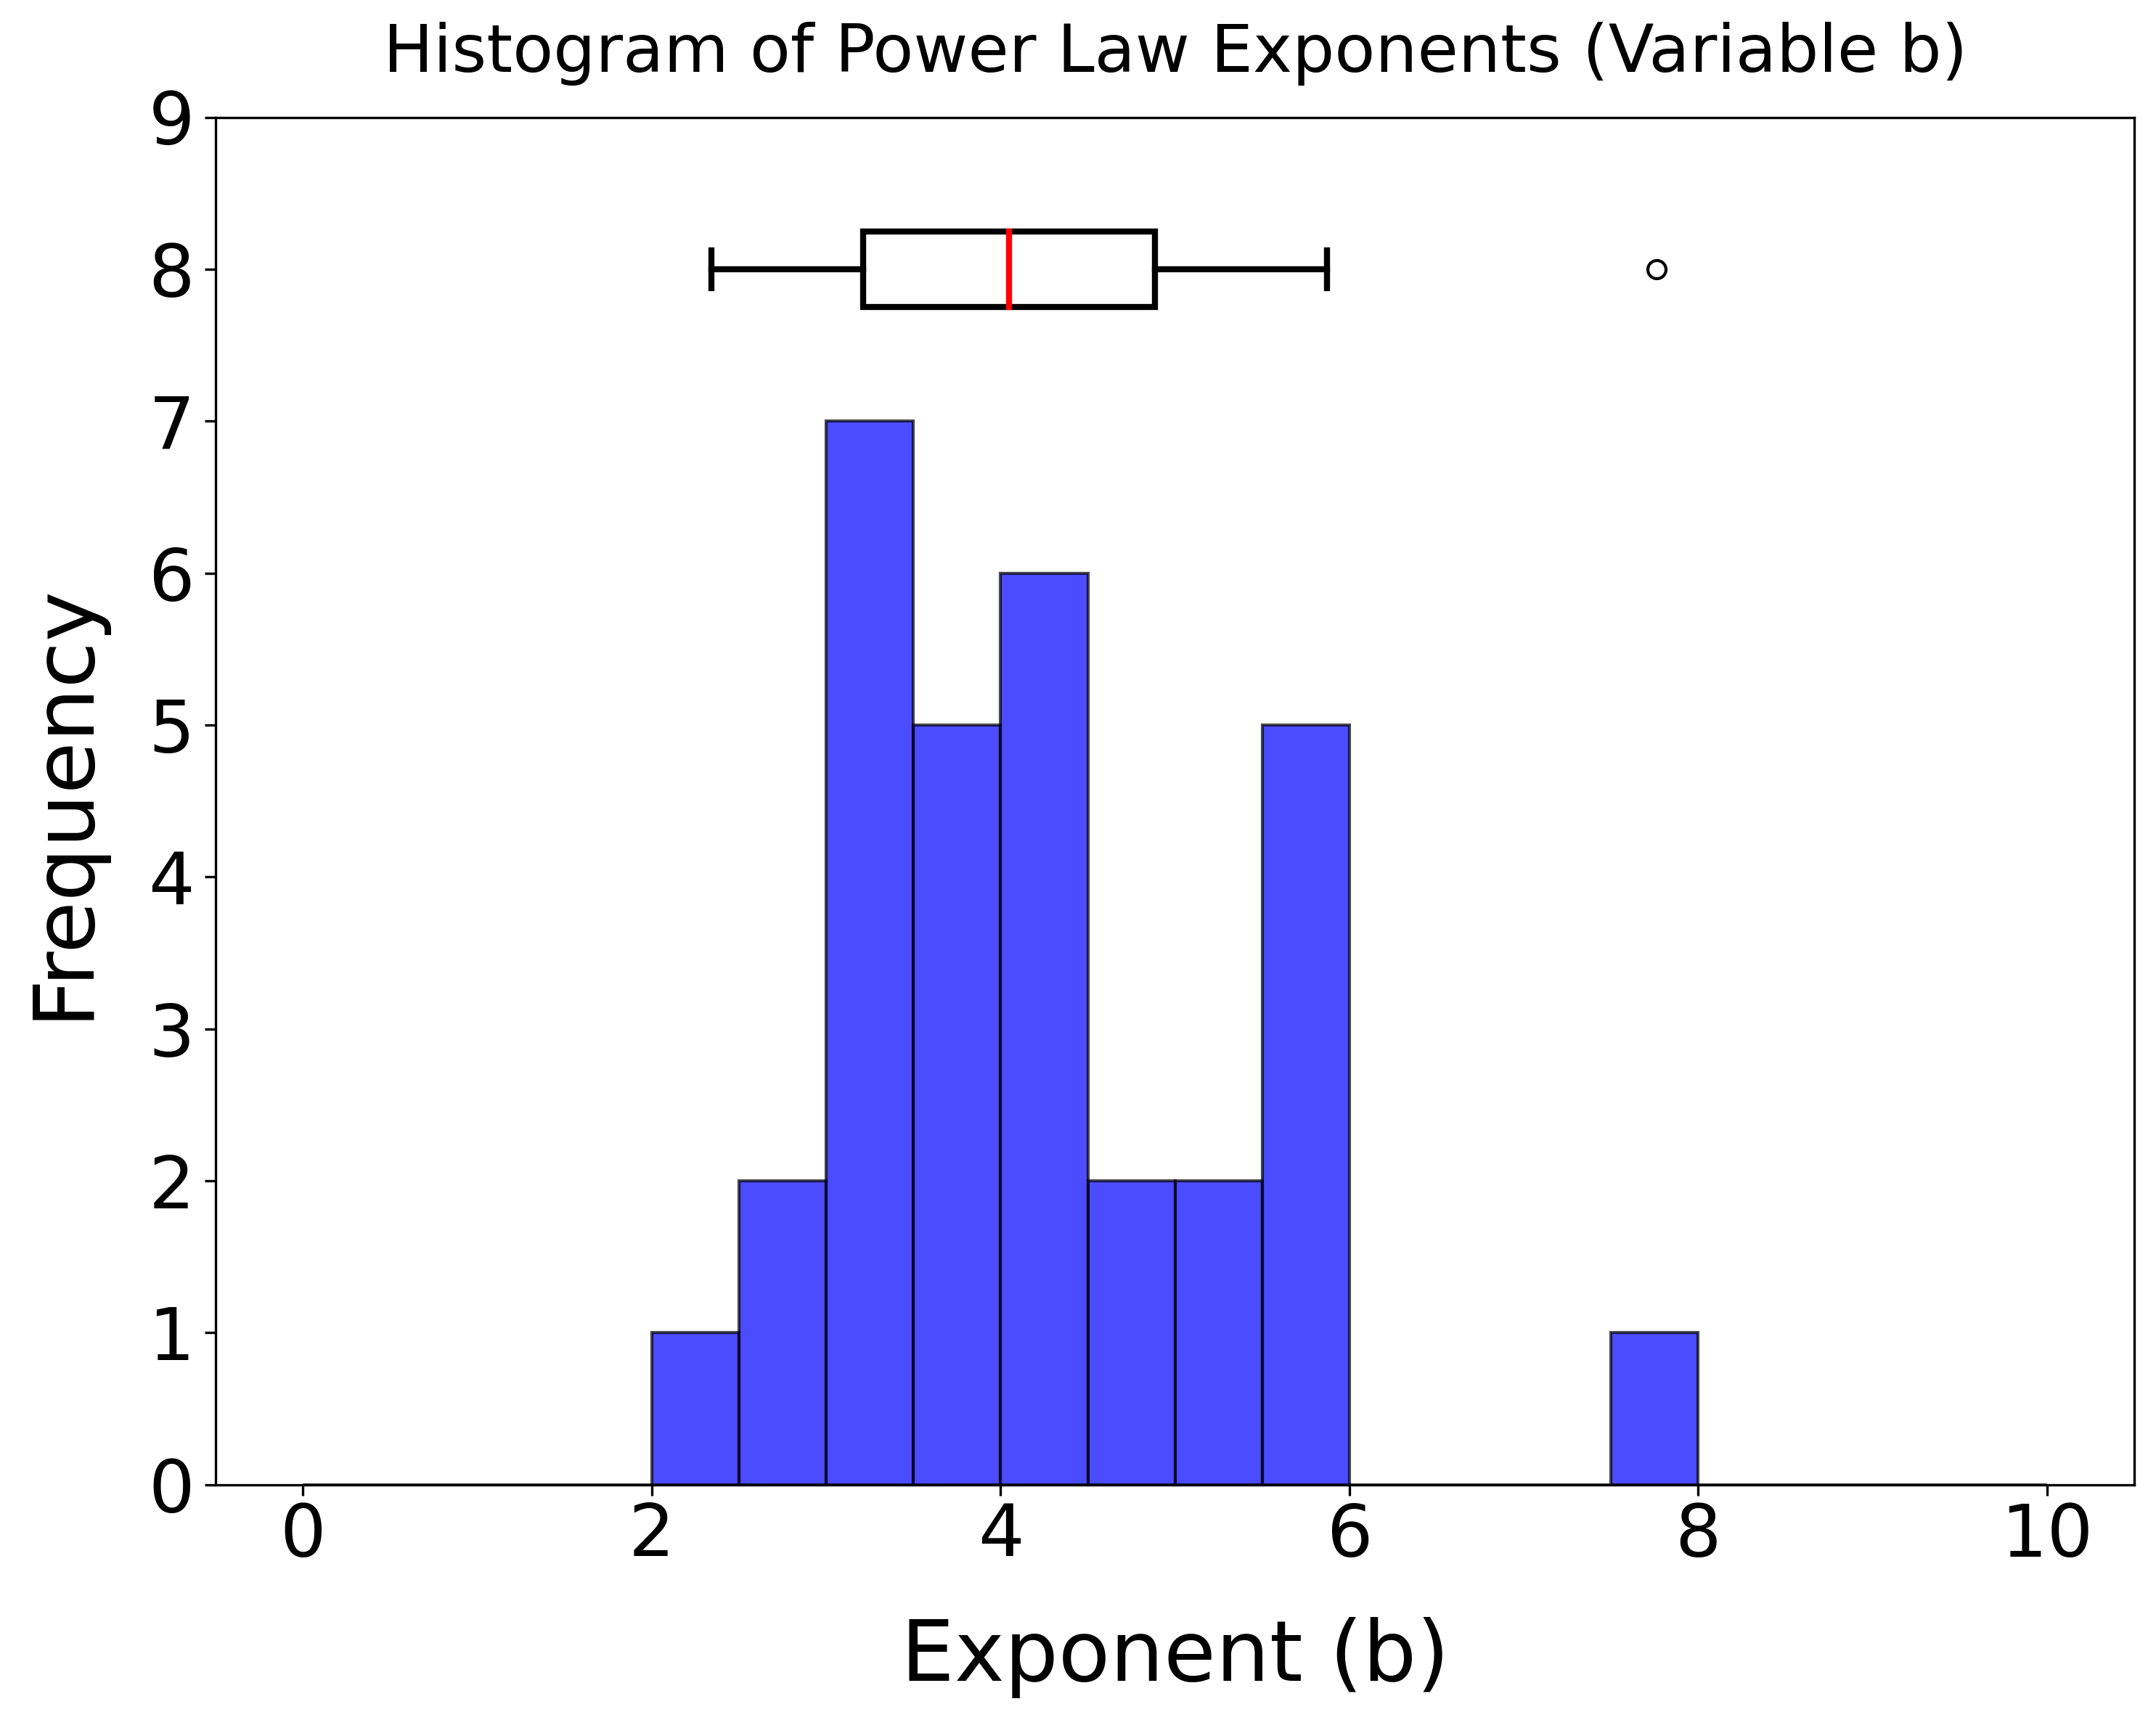

In [58]:
import matplotlib.pyplot as plt

# Customizable parameters
FIGURE_WIDTH = 10
FIGURE_HEIGHT = 8
TITLE_FONTSIZE = 22
LABEL_FONTSIZE = 28
TICK_FONTSIZE = 24
DPI = 300
HIST_BINS = 20
SLOPE_RANGE = (0, 10)
Y_AXIS_LIMIT = 9
BOX_PLOT_POSITION = 8.0
BOX_PLOT_WIDTH = 0.5
LABEL_PAD = 15  # Padding between axis labels and tick labels
BOX_LINEWIDTH = 2  # Line width for box plot elements
X_AXIS_GAP = 0.05  # Gap at the start and end of x-axis (as a fraction of the total range)

# Create a figure with one subplot
fig, ax1 = plt.subplots(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT), dpi=DPI)

# Histogram for Slope Values (Variable b)
slope_data = master_results_df['Slope_b']
n, bins, patches = ax1.hist(
    slope_data,
    bins=HIST_BINS,
    range=SLOPE_RANGE,
    edgecolor='black',
    color='blue',
    alpha=0.7
)
ax1.set_xlabel('Exponent (b)', fontsize=LABEL_FONTSIZE, labelpad=LABEL_PAD)
ax1.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE, labelpad=LABEL_PAD)
ax1.set_title(
    'Histogram of Power Law Exponents (Variable b)',
    fontsize=TITLE_FONTSIZE,
    pad=LABEL_PAD
)

# Adjust x-axis limits to create a gap
slope_range_width = SLOPE_RANGE[1] - SLOPE_RANGE[0]
x_min = SLOPE_RANGE[0] - X_AXIS_GAP * slope_range_width
x_max = SLOPE_RANGE[1] + X_AXIS_GAP * slope_range_width
ax1.set_xlim(x_min, x_max)

ax1.set_ylim(0, Y_AXIS_LIMIT)
ax1.tick_params(axis='both', labelsize=TICK_FONTSIZE)

# Overlay box plot for Slope Values
ax1_box = ax1.twinx()
bp = ax1_box.boxplot(
    slope_data,
    vert=False,
    positions=[BOX_PLOT_POSITION],
    widths=[BOX_PLOT_WIDTH],
    patch_artist=True,
    boxprops=dict(facecolor="white", color="black", linewidth=BOX_LINEWIDTH),
    medianprops=dict(color="red", linewidth=BOX_LINEWIDTH),
    whiskerprops=dict(color="black", linewidth=BOX_LINEWIDTH),
    capprops=dict(color="black", linewidth=BOX_LINEWIDTH)
)
ax1_box.set_ylim(0, Y_AXIS_LIMIT)
ax1_box.axis('off')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()
